In [1]:
import numpy as np

from matplotlib import pyplot as plt

import sys
sys.path.append("..")

from tiny_xgboost import TinyXGBRegressor

In [2]:
np.random.seed(1)


def gen_data(n=50, bound=1, deg=3, beta=1, noise=0.9, intcpt=-1):
    x = np.linspace(-bound, bound, n)[:, np.newaxis]
    h = np.linspace(-bound, bound, n)[:, np.newaxis]
    e = np.random.randn(*x.shape) * (0.1 + 10 * np.abs(x))
    y = 50 * (x**deg) + h * beta + noise * e + intcpt
    return x, y.squeeze(), np.c_[h, np.ones_like(h)]

X, y, _ = gen_data(n=100)

In [3]:
model = TinyXGBRegressor(
    objective="distribution:normal",
    max_depth=1,
    n_estimators=10,
    learning_rate=0.1,
)
model, debug = model.fit(
    X, y, eval_set=(X, y), debug=True
)

[0]	train-loss=78.58617, val-loss=78.58617
[1]	train-loss=72.45425, val-loss=72.45425
[2]	train-loss=70.06980, val-loss=70.06980
[3]	train-loss=64.92426, val-loss=64.92426
[4]	train-loss=145.14250, val-loss=145.14250
[5]	train-loss=132.48272, val-loss=132.48272
[6]	train-loss=151.74660, val-loss=151.74660
[7]	train-loss=141.89364, val-loss=141.89364
[8]	train-loss=129.71048, val-loss=129.71048
[9]	train-loss=118.45056, val-loss=118.45056


In [4]:
debug[0].keys()

dict_keys(['grad', 'hess', 'splits'])

In [5]:
iteration = 4  # for the plots below

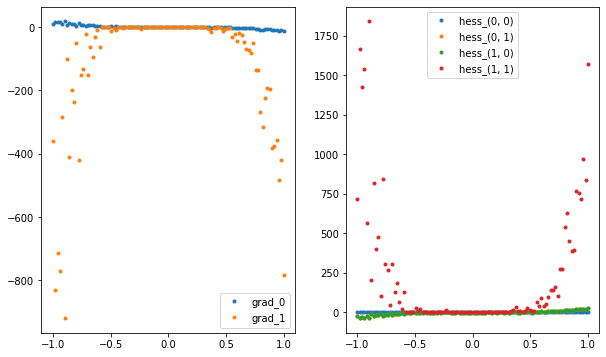

In [6]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=2, nrows=1)

axes = axes.flatten()

for i in [0, 1]:
    axes[0].plot(
        X,
        debug[iteration]["grad"][:, i],
        "o",
        markersize=3,
        label=f"grad_{i}"
    )
    axes[0].legend()


for ij in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    axes[1].plot(
        X,
        debug[iteration]["hess"][:, ij[0], ij[1]],
        "o",
        markersize=3,
        label=f"hess_{ij}"
    )
    axes[1].legend()

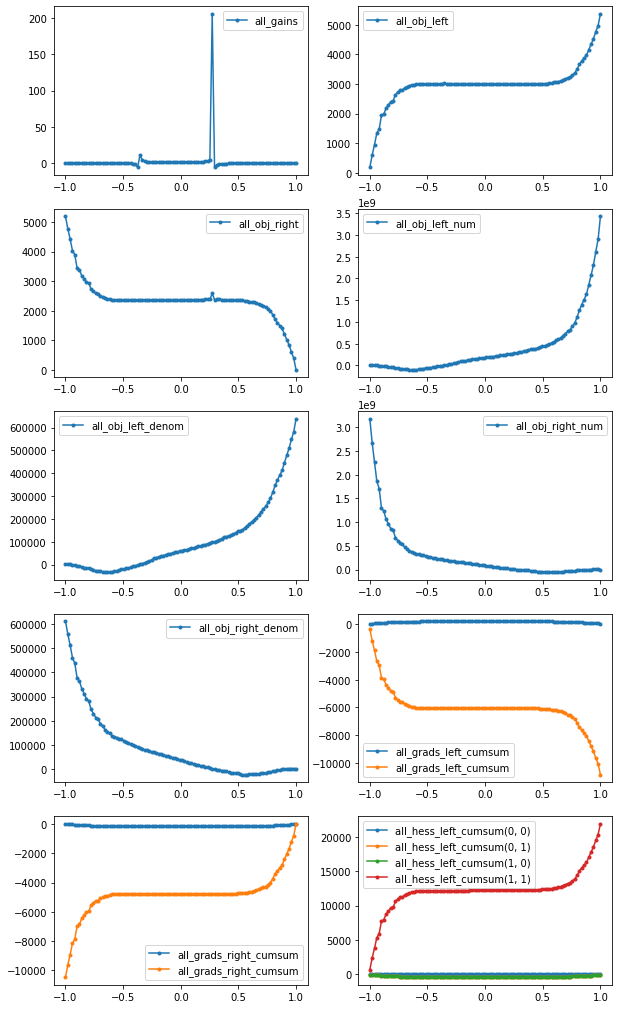

In [7]:
fig, axes = plt.subplots(figsize=(10, 18), ncols=2, nrows=5)

axes = axes.flatten()

ys = [
    "all_gains",
    "all_obj_left",
    "all_obj_right",
    "all_obj_left_num",
    "all_obj_left_denom",
    "all_obj_right_num",
    "all_obj_right_denom",
    "all_grads_left_cumsum",
    "all_grads_right_cumsum",
    "all_hess_left_cumsum"
]

for ii, (y_label, ax) in enumerate(zip(ys, axes)):
    y_plt = debug[iteration]["splits"]["depth_0"][y_label]
    if len(y_plt.shape) == 3:
        for ij in [(0, 0), (0, 1), (1, 0), (1, 1)]:
            ax.plot(
                debug[iteration]["splits"]["depth_0"]["all_feature_values"],
                y_plt[:, ij[0], ij[1]], 
                "-o",
                markersize=3,
                label=y_label+str(ij)
            )
    else:
        ax.plot(
            debug[iteration]["splits"]["depth_0"]["all_feature_values"],
            y_plt, 
            "-o",
            markersize=3,
            label=y_label
        )
    ax.legend()


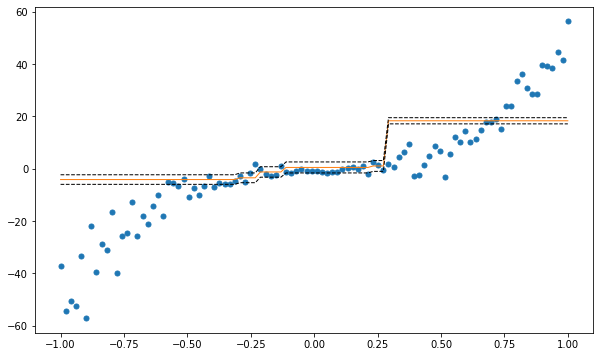

In [8]:
preds = model.predict(X, iteration_range=(0, iteration+1))
loc, scale = preds[:, 0], preds[:, 1]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(X, y, "o", markersize=5)
ax.plot(X, loc, "-", linewidth=1)
ax.plot(X, loc-scale, "k--", linewidth=1)
ax.plot(X, loc+scale, "k--", linewidth=1)